## Imports

In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from feature_engine.outliers import OutlierTrimmer

from pydtmc import MarkovChain

DATA_DIR = 'data'

## Load relevant dataframes

In [38]:
activities = pd.read_csv(f'{DATA_DIR}/activity.csv')
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

In [39]:
activities = activities[['user_id', 'course_id', 'activity_type', 'activity_started', 'activity_completed']]
all_scores = all_scores[['user_id', 'course', 'percentage']]

### Remove old dates, outliers, long  and missing durations

In [40]:
activities = activities[activities['course_id'].isin(all_scores.course.unique())]
# Drop irrelevant activity types
activities = activities[~activities['activity_type'].isin(['exam','group_progress','access'])]

activities = activities.dropna(subset=['activity_started', 'activity_completed'])
activities['activity_started'] = pd.to_datetime(activities['activity_started'], unit='s')
activities['activity_completed'] = pd.to_datetime(activities['activity_completed'], unit='s')
activities['duration'] = activities['activity_completed'] - activities['activity_started']

print(activities.shape)
activities = activities[
    (activities['duration'] >= pd.Timedelta(0)) &
    (activities['duration'] <= pd.Timedelta(hours=24)) &
    (activities['activity_started'].dt.year > 2022)
]
print(activities.shape)

activities['duration_minutes'] = activities['duration'].dt.total_seconds()/60

activities_before = activities.copy()
trimmer = OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5, variables=['duration_minutes'])
activities = trimmer.fit_transform(activities)

print(activities.shape)

(36894, 6)
(23001, 6)
(19929, 7)


In [41]:
activities.describe()

,user_id,course_id,activity_started,activity_completed,duration,duration_minutes
count,19929.000000,19929.000000,19929,19929,19929,19929.000000
mean,2259.083396,2705.129409,2024-11-09 08:55:48.275728640,2024-11-09 09:05:20.817351680,0 days 00:09:32.541622760,9.542360
min,1.000000,42.000000,2023-04-07 16:42:38,2023-04-07 16:43:58,0 days 00:00:02,0.033333
25%,329.000000,42.000000,2024-10-09 10:20:32,2024-10-09 10:30:18,0 days 00:00:54,0.900000
50%,3182.000000,3301.000000,2024-11-14 17:49:04,2024-11-14 17:57:28,0 days 00:04:24,4.400000
75%,3881.000000,3865.000000,2025-01-01 15:58:53,2025-01-01 16:01:31,0 days 00:13:19,13.316667
max,4095.000000,5447.000000,2025-03-07 06:42:09,2025-03-07 06:57:30,0 days 00:55:52,55.866667
std,1721.925101,1972.971233,NaN,NaN,0 days 00:12:11.166207416,12.186103


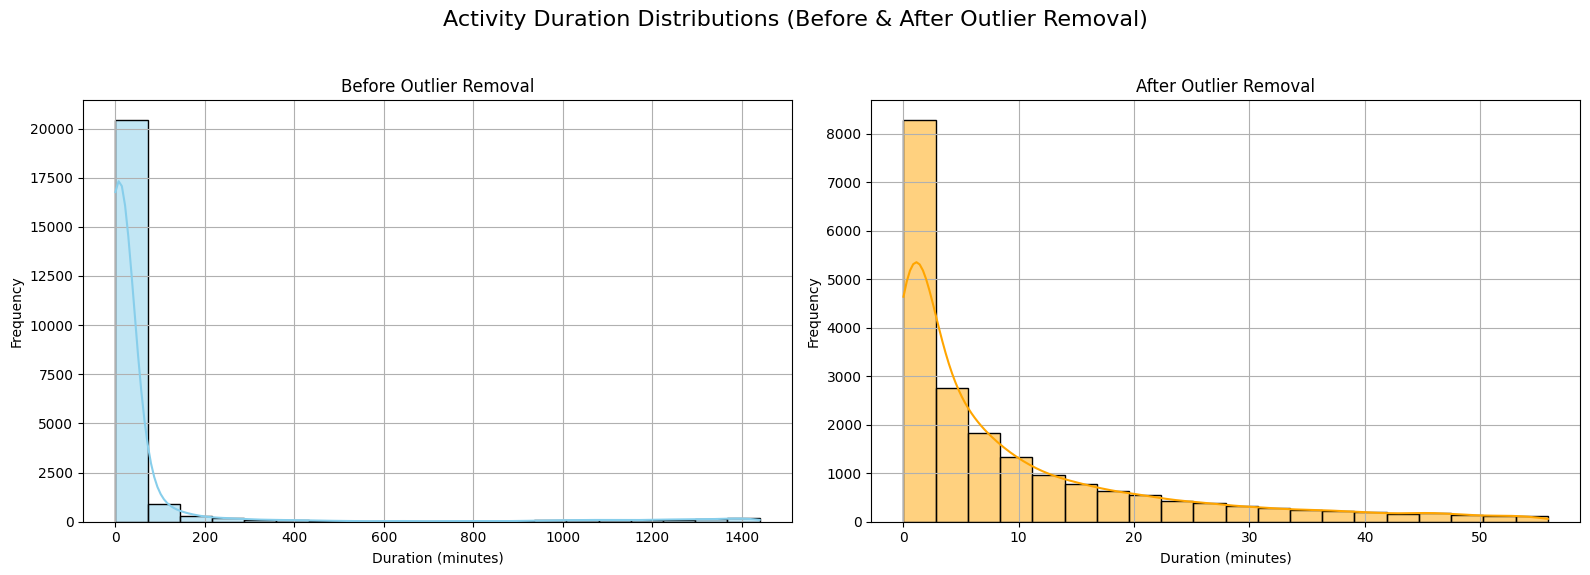

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Activity Duration Distributions (Before & After Outlier Removal)", fontsize=16)

sns.histplot(activities_before['duration_minutes'], bins=20, color='skyblue', ax=axes[0], kde=True)
axes[0].set_title('Before Outlier Removal')
axes[0].set_xlabel('Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

sns.histplot(activities['duration_minutes'], bins=20, color='orange', ax=axes[1], kde=True)
axes[1].set_title('After Outlier Removal')
axes[1].set_xlabel('Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate zscores on a per course basis, keep percentages for visualizations

In [43]:
df = all_scores.copy()
df["zscore"] = df.groupby("course")["percentage"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
zscores = df.rename(columns={'course': 'course_id'})

zscores.describe()

,user_id,course_id,percentage,zscore
count,6432.000000,6432.000000,6432.000000,6.432000e+03
mean,2420.168999,2894.153141,56.098510,-1.115747e-16
std,1698.985735,2011.163854,29.366960,1.000078e+00
min,1.000000,42.000000,0.000000,-5.423334e+00
25%,332.000000,42.000000,36.099727,-6.343278e-01
50%,3503.000000,3865.000000,62.500000,2.908645e-02
75%,3932.000000,3865.000000,78.000000,7.789549e-01
max,4095.000000,5447.000000,100.000000,3.370601e+00


In [44]:
# Create mapping course_id -> course name/short name

class SmartMap(dict):
    def __missing__(self, key):
        return f"Unknown({key})"
    
course_map = SmartMap({
    42 : 'Langzeitgymnasium maths',
    3865 : 'Kurzzeitgymnasium maths',
    5447 : 'Langzeitgymnasium essay',
    2115 : 'Langzeitgymnasium text comprehension',
    5009 : 'Kurzzeitgymnasium text comprehension',
    3301 : 'Kurzzeitgymnasium essay',
    1696 : 'Student site introduction',
    8117 : 'Teacher site introduction'
})

course_map_short = SmartMap({
    42 : 'LZG_M',
    3865 : 'KZG_M',
    5447 : 'LZG_E',
    2115 : 'LZG_TC',
    5009 : 'KZG_TC',
    3301 : 'KZG_E',
    1696 : 'SSI',
    8117 : 'TSI'
})

## Cook some dataframes for analysis

In [45]:
course_median_duration = activities.groupby(['course_id', 'activity_type'])['duration'].median().reset_index()
print(course_median_duration)

    course_id activity_type               duration
0          42        lesson 0 days 00:11:48.500000
1          42          quiz 0 days 00:05:07.500000
2          42         topic        0 days 00:02:02
3        2115        lesson        0 days 00:03:42
4        2115         topic 0 days 00:01:54.500000
5        3301        lesson        0 days 00:18:01
6        3301          quiz 0 days 00:03:50.500000
7        3301         topic        0 days 00:06:39
8        3865        lesson        0 days 00:07:58
9        3865          quiz        0 days 00:10:47
10       3865         topic        0 days 00:04:05
11       5009        lesson        0 days 00:14:07
12       5009         topic        0 days 00:03:45
13       5447        lesson        0 days 00:11:05
14       5447          quiz 0 days 00:02:56.500000
15       5447         topic        0 days 00:05:05


In [46]:
# GPT-generated visualization

def plot_course_durations(df_median, course_map_short):
    # Prepare the data
    df_median = df_median.copy()
    df_median['duration_sec'] = df_median['duration'].dt.total_seconds()
    
    total_durations = df_median.groupby('course_id')['duration_sec'].sum()
    max_total_duration = total_durations.max()

    # Color map for activities
    activity_types = sorted(df_median['activity_type'].unique())
    cmap = plt.get_cmap('Set2')
    colors = cmap(np.linspace(0, 1, len(activity_types)))
    color_map = dict(zip(activity_types, colors))

    # Plot settings
    courses = total_durations.sort_values(ascending=False).index
    n_courses = len(courses)
    n_cols = 3
    n_rows = int(np.ceil(n_courses / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    for idx, course_id in enumerate(courses):
        ax = axes[idx]
        course_data = df_median[df_median['course_id'] == course_id]
        durations = course_data['duration_sec'].values
        labels = course_data['activity_type'].values

        total_duration = durations.sum()
        course_fraction = total_duration / max_total_duration
        max_angle = 360 * course_fraction  # Total filled angle for this course

        # Compute sizes in angles instead of fractions of 1
        sizes = durations / total_duration * max_angle

        start_angle = 90
        for label, size in zip(labels, sizes):
            ax.pie(
                [size, 360 - size], 
                colors=[color_map[label], (0, 0, 0, 0)],  # Transparent for remaining part
                startangle=start_angle, 
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )
            start_angle -= size  # Update start angle for next segment

        # Draw the remaining transparent gap (optional light gray)
        if course_fraction < 1:
            ax.pie(
                [360 * (1 - course_fraction), 360 * course_fraction],
                colors=['#f0f0f0', (0, 0, 0, 0)],
                startangle=90 - max_angle,
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )

        # Add center text
        course_name = course_map_short.get(course_id, course_id)
        total_hours = int(total_duration // 3600)
        total_minutes = int((total_duration % 3600) // 60)
        ax.text(0, 0.1, course_name, ha='center', va='center', fontsize=12, weight='bold')
        ax.text(0, -0.1, f"{total_hours}h {total_minutes}m", ha='center', va='center', fontsize=10)
        
        ax.set_aspect('equal')
        ax.axis('off')
    
    # Remove unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    # Add Legend
    legend_patches = [mpatches.Patch(color=color_map[act], label=act) for act in activity_types]
    fig.legend(
        handles=legend_patches, 
        loc='upper right', 
        fontsize=10, 
        title='Activity Types'
    )
    plt.title("Course Durations", fontsize=16, loc='center')

    
    plt.tight_layout()
    plt.show()


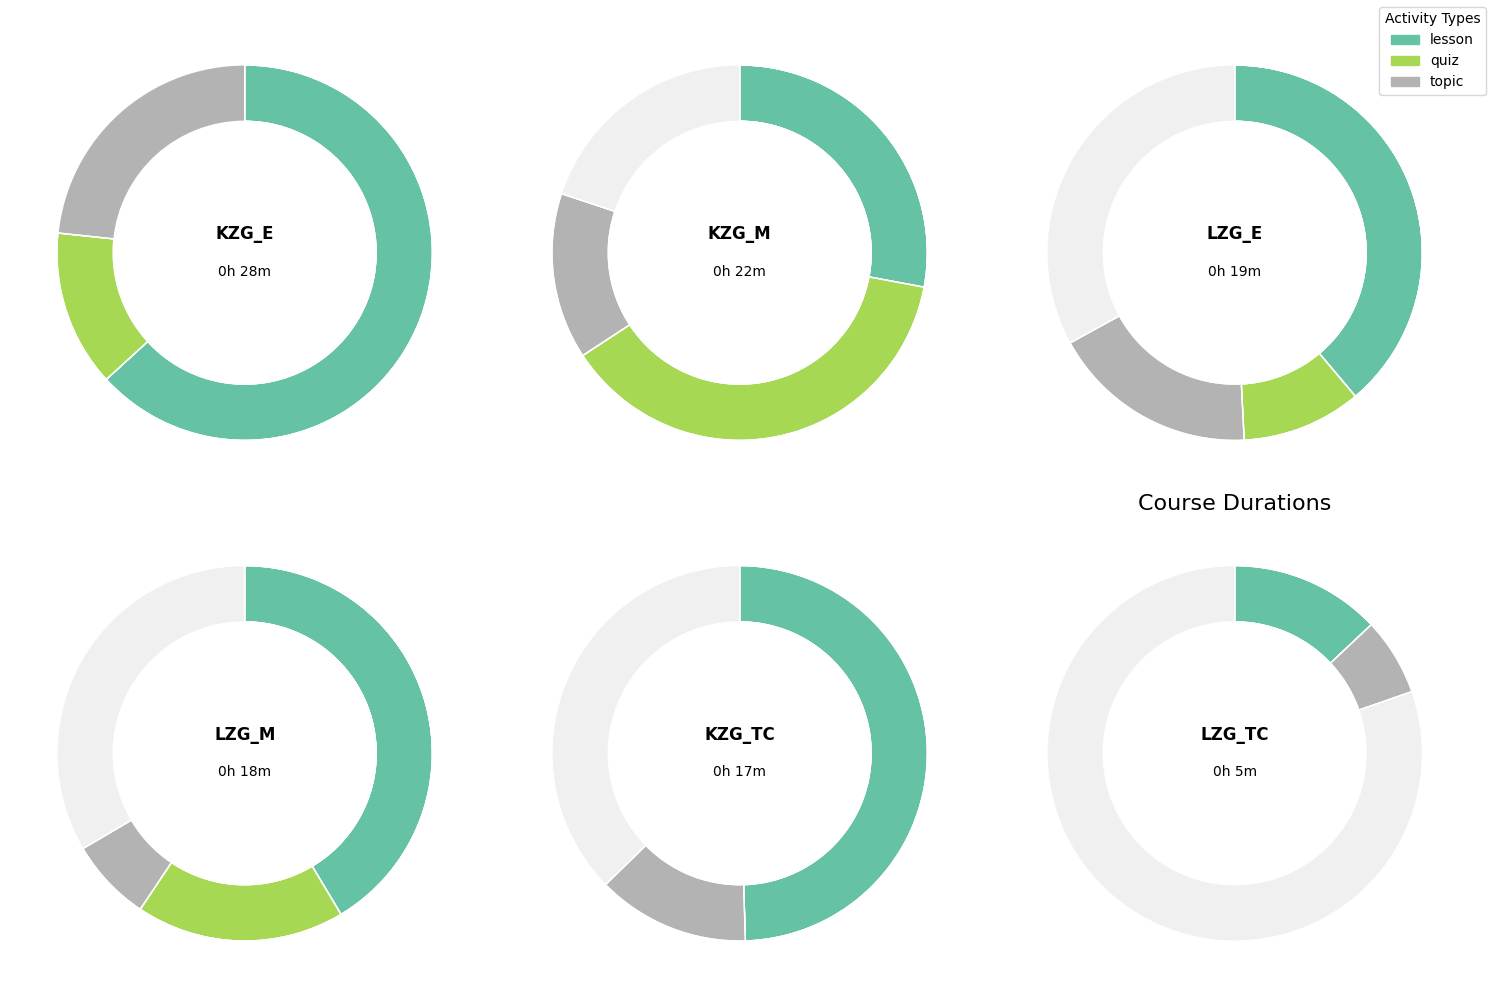

In [47]:
plot_course_durations(course_median_duration, course_map_short)

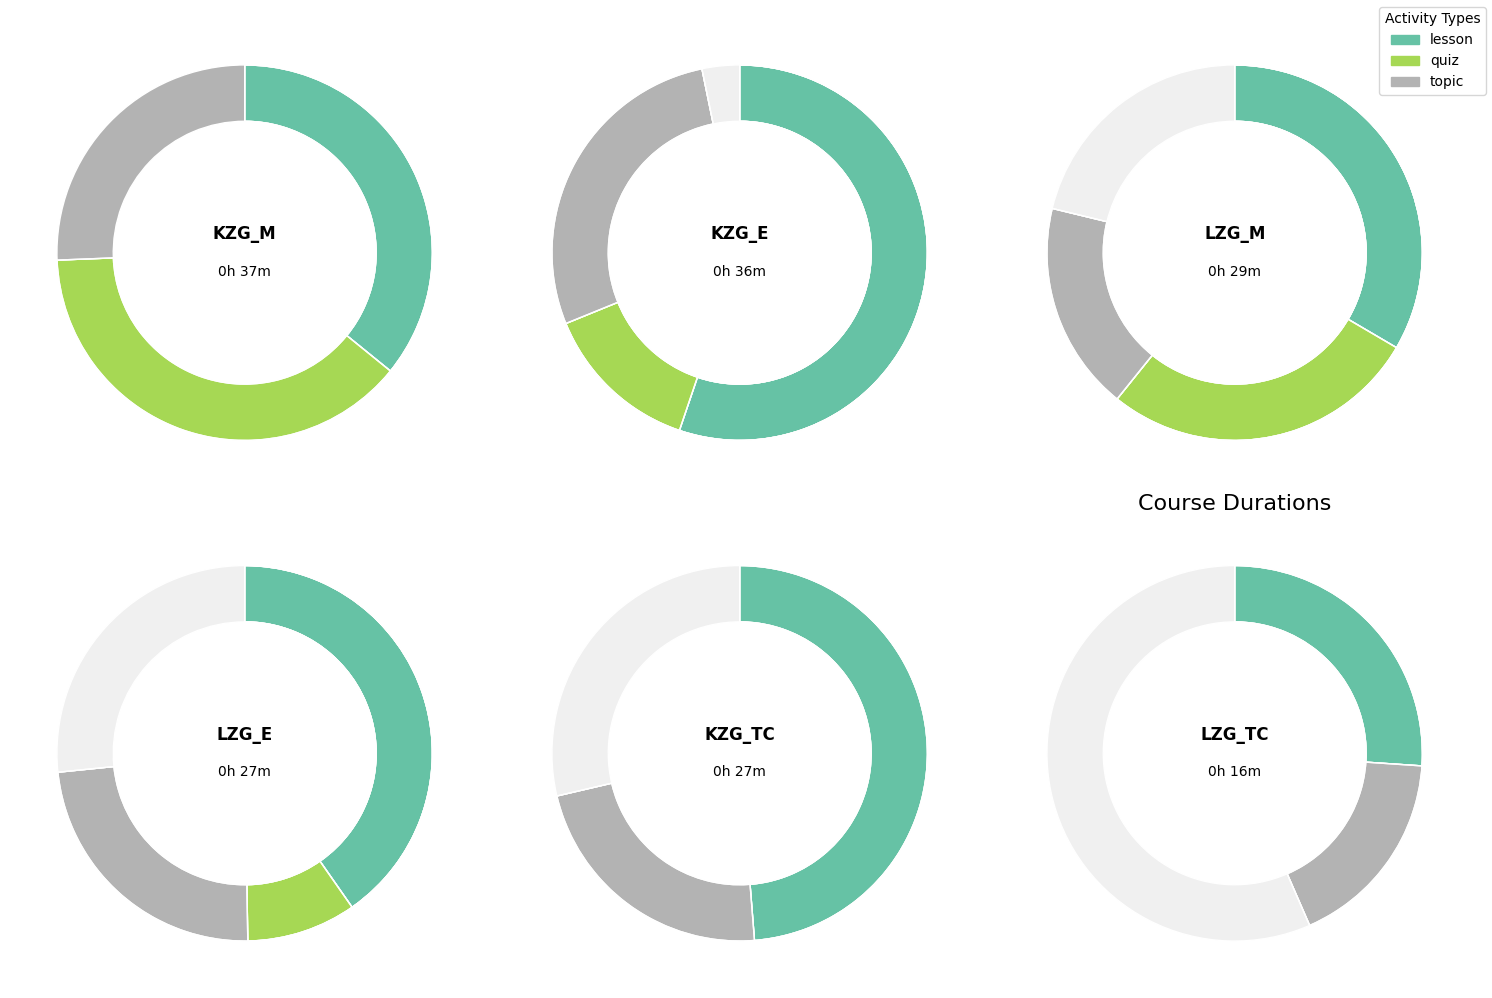

In [48]:
plot_course_durations(activities.groupby(['course_id', 'activity_type'])['duration'].mean().reset_index(), course_map_short)

In [49]:
activities_copy = activities.copy(deep=True)

In [50]:
course_median_duration.activity_type.unique()

array(['lesson', 'quiz', 'topic'], dtype=object)

In [51]:
activities.columns

Index(['user_id', 'course_id', 'activity_type', 'activity_started',
       'activity_completed', 'duration', 'duration_minutes'],
      dtype='object')

In [52]:
activities.dtypes

user_id                         int64
course_id                       int64
activity_type                  object
activity_started       datetime64[ns]
activity_completed     datetime64[ns]
duration              timedelta64[ns]
duration_minutes              float64
dtype: object

In [53]:
course_median_duration.columns

Index(['course_id', 'activity_type', 'duration'], dtype='object')

In [54]:
course_median_duration.dtypes

course_id                  int64
activity_type             object
duration         timedelta64[ns]
dtype: object

In [55]:
def compute_zscore_duration(df, user_agg='sum'):
    """
    Compute z-score normalized duration for each user per (course_id, activity_type) pair.

    Parameters:
        df: pd.DataFrame with columns: user_id, course_id, activity_type, duration
        user_agg: str, 'sum' or 'mean'

    Returns:
        pd.DataFrame with: user_id, course_id, activity_type, duration, mean_duration, std_duration, zscore_duration
    """
    # 1. Aggregate per user per (course_id, activity_type)
    user_activity = (
        df.groupby(['user_id', 'course_id', 'activity_type'], as_index=False)
          .agg({'duration': user_agg})
    )

    # 2. Compute mean and std per (course_id, activity_type)
    stats = (
        user_activity.groupby(['course_id', 'activity_type'])['duration']
        .agg(['mean', 'std']).reset_index()
        .rename(columns={'mean': 'mean_duration', 'std': 'std_duration'})
    )

    # 3. Merge
    merged = user_activity.merge(stats, on=['course_id', 'activity_type'], how='left')

    # 4. Z-score
    merged['zscore_duration'] = (merged['duration'] - merged['mean_duration']) / merged['std_duration']

    return merged[['user_id', 'course_id', 'activity_type', 'duration', 'mean_duration', 'std_duration', 'zscore_duration']]


In [56]:
zduration_sum = compute_zscore_duration(activities, 'sum')

In [57]:
zduration_sum

,user_id,course_id,activity_type,duration,mean_duration,std_duration,zscore_duration
0,1,3301,quiz,0 days 00:04:59,0 days 00:06:16.612121212,0 days 00:05:57.196666262,-0.217281
1,1,3301,topic,0 days 00:00:11,0 days 01:01:16.201716738,0 days 00:56:35.367471301,-1.079471
2,1,3865,quiz,0 days 00:19:26,0 days 02:48:46.236607142,0 days 02:33:54.677760883,-0.970281
3,1,3865,topic,0 days 00:56:11,0 days 01:48:34.604095563,0 days 01:46:45.686579520,-0.490752
4,1,5009,topic,0 days 03:05:13,0 days 01:26:28.571428571,0 days 01:28:26.502501462,1.116447
...,...,...,...,...,...,...,...
2644,4092,5447,topic,0 days 00:29:38,0 days 01:01:50.076305220,0 days 01:00:38.938257699,-0.530945
2645,4095,3301,quiz,0 days 00:04:07,0 days 00:06:16.612121212,0 days 00:05:57.196666262,-0.362859
2646,4095,3301,topic,0 days 01:09:41,0 days 01:01:16.201716738,0 days 00:56:35.367471301,0.148673
2647,4095,3865,quiz,0 days 01:12:30,0 days 02:48:46.236607142,0 days 02:33:54.677760883,-0.625494


In [58]:
activities

,user_id,course_id,activity_type,activity_started,activity_completed,duration,duration_minutes
19,2533,42,topic,2023-04-07 16:42:38,2023-04-07 16:43:58,0 days 00:01:20,1.333333
20,2533,42,topic,2023-04-07 16:43:59,2023-04-07 16:46:13,0 days 00:02:14,2.233333
21,2533,42,topic,2023-04-07 16:46:14,2023-04-07 16:46:27,0 days 00:00:13,0.216667
22,2533,42,topic,2023-04-07 16:46:28,2023-04-07 16:48:11,0 days 00:01:43,1.716667
23,2533,42,topic,2023-04-07 16:48:12,2023-04-07 16:54:48,0 days 00:06:36,6.600000
...,...,...,...,...,...,...,...
70259,958,42,quiz,2025-03-06 19:28:56,2025-03-06 19:57:09,0 days 00:28:13,28.216667
70262,955,42,topic,2025-03-07 06:33:02,2025-03-07 06:57:30,0 days 00:24:28,24.466667
70266,955,42,topic,2025-03-07 06:33:15,2025-03-07 06:39:05,0 days 00:05:50,5.833333
70267,955,42,topic,2025-03-07 06:33:16,2025-03-07 06:54:21,0 days 00:21:05,21.083333


In [59]:
user_daily_activity = activities.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Ceate a csv of user_ids, gap_days where gap_days is a list of the gaps (ignore nans) in increasing order. Use copies of the dataframes
df = user_daily_activity.copy(deep=True)[['user_id', 'gap_days']]
# Remove the first gap_days (nan) for each user
df.dropna(subset=['gap_days'], inplace=True)
# Group by user_id and aggregate the gap_days into a list
df = df.groupby('user_id')['gap_days'].apply(lambda x: list(x)).reset_index()
# Sort the gap_days list for each user
df['gap_days'] = df['gap_days'].apply(lambda x: sorted(x))

gap_days = df.copy(deep=True)

# Save to csv
gap_days.to_csv(f'{DATA_DIR}/user_gap_days.csv', index=False)

In [60]:
gap_days

,user_id,gap_days
0,1,"[1.0, 1.0, 2.0, 2.0, 2.0, 4.0, 4.0, 7.0, 19.0,..."
1,4,"[2.0, 6.0, 7.0, 8.0, 13.0, 51.0]"
2,6,"[2.0, 2.0, 6.0, 6.0, 8.0, 14.0, 20.0, 44.0]"
3,7,"[1.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, ..."
4,9,"[2.0, 7.0, 8.0, 12.0, 18.0, 24.0, 25.0]"
...,...,...
600,4087,"[1.0, 1.0, 2.0, 4.0, 5.0, 5.0, 8.0, 11.0, 11.0..."
601,4089,"[1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 5.0, 14.0]"
602,4090,[69.0]
603,4092,"[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 4.0, ..."


In [61]:
transitions = activities.copy()

transitions.sort_values(by=['user_id', 'activity_started'], ascending=True, inplace=True)

# Build activity_state = (activity_type, course_id) and log durations where possible
transitions['activity_state'] = transitions['activity_type'] + '_' + transitions['course_id'].map(course_map_short).fillna('Unknown')


# Index states numerically
state_to_idx = {s: i for i, s in enumerate(transitions['activity_state'].unique())}
transitions['state_idx'] = transitions['activity_state'].map(state_to_idx)

# Log subsequent states into a separate column
transitions['next_state_idx'] = transitions.groupby('user_id')['state_idx'].shift(-1)
transitions = transitions.dropna(subset=['next_state_idx']).copy()
transitions['next_state_idx'] = transitions['next_state_idx'].astype(int)



all_states = transitions['activity_state'].unique().tolist()
n_states = len(all_states)


In [62]:
final_transitions = transitions[['user_id', 'activity_state', 'state_idx', 'next_state_idx']]
final_transitions

,user_id,activity_state,state_idx,next_state_idx
36137,1,quiz_KZG_E,0,1
45192,1,topic_KZG_TC,1,1
45206,1,topic_KZG_TC,1,1
46437,1,topic_KZG_TC,1,1
47334,1,topic_KZG_TC,1,1
...,...,...,...,...
48050,4095,topic_KZG_M,3,3
48051,4095,topic_KZG_M,3,4
48266,4095,quiz_KZG_M,4,4
48272,4095,quiz_KZG_M,4,4


In [63]:
# Per-user Markov chains
user_chains = {}

for user_id, group in final_transitions.groupby('user_id'):
    matrix = np.zeros((n_states, n_states), dtype=float)
    # Vectorized accumulation of transition counts
    np.add.at(matrix, (group['state_idx'], group['next_state_idx']), 1)
    
    # Normalize rows and handle dead-end states with self-loops
    row_sums = matrix.sum(axis=1, keepdims=True)
    for idx, row_sum in enumerate(row_sums.flatten()):
        if row_sum == 0:
            matrix[idx, idx] = 1  # Self-loop
        else:
            matrix[idx] /= row_sum  # Normalize row to sum to 1
    
    mc = MarkovChain(matrix.tolist(), all_states)
    user_chains[user_id] = mc

# ✅ Example: Inspect User 1's Model
print(f"User 1 Transition Matrix:\n{np.round(user_chains[1].p, 2)}")
print(f"States: {user_chains[1].states}")


User 1 Transition Matrix:
[[0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.92 0.08 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.75 0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  

### GUI to explore users' markov chains

#### You can observe what each user's working on: user 22 for example is only doing long-time gymnasium essays

In [64]:
import ipywidgets as widgets
import networkx as nx
import plotly.graph_objs as go
from IPython.display import display
import numpy as np

def plot_user_markov_with_edge_labels(user_id):
    mc = user_chains[user_id]
    matrix = np.array(mc.p)
    states = mc.states

    # Identify non-trivial states
    non_trivial_states = set()
    for i, state in enumerate(states):
        row = matrix[i]
        col = matrix[:, i]
        if not (np.isclose(row[i], 1.0) and np.isclose(row.sum(), 1.0) and np.isclose(col.sum(), 1.0)):
            non_trivial_states.add(state)

    # Build filtered graph
    G = nx.DiGraph()
    for i, from_state in enumerate(states):
        if from_state not in non_trivial_states:
            continue
        for j, to_state in enumerate(states):
            if to_state in non_trivial_states and matrix[i, j] > 0:
                G.add_edge(from_state, to_state, weight=round(matrix[i, j], 2))

    if len(G.nodes) == 0:
        print(f"No significant transitions to visualize for User {user_id}.")
        return

    pos = nx.spring_layout(G, seed=42)  # Better separation

    edge_traces = []
    edge_annotations = []

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2]['weight']

        # Compute curvature offset
        offset = 0.1 if G.has_edge(edge[1], edge[0]) and edge[0] != edge[1] else 0
        ctrl_x = (x0 + x1) / 2 + offset * (y1 - y0)
        ctrl_y = (y0 + y1) / 2 + offset * (x0 - x1)

        curve_x = [x0, ctrl_x, x1]
        curve_y = [y0, ctrl_y, y1]

        edge_traces.append(go.Scatter(
            x=curve_x, y=curve_y,
            line=dict(width=2, color='gray', shape='spline'),
            mode='lines',
            hoverinfo='none'
        ))

        # Label near the curve's control point
        edge_annotations.append(dict(
            x=ctrl_x, y=ctrl_y,
            xref='x', yref='y',
            text=f"{weight}",
            showarrow=False,
            font=dict(color='black', size=14),
            bgcolor='rgba(255, 255, 255, 0.7)',
            bordercolor='black',
            borderwidth=1,
            borderpad=2,
            align='center',
            opacity=0.9
        ))

        # Arrow at the end
        edge_annotations.append(dict(
            ax=ctrl_x, ay=ctrl_y,
            x=x1, y=y1,
            axref='x', ayref='y',
            xref='x', yref='y',
            showarrow=True,
            arrowhead=3,
            arrowsize=2,
            arrowwidth=2,
            arrowcolor='gray',
            opacity=0.8
        ))

    # Node Trace
    node_trace = go.Scatter(
        x=[pos[node][0] for node in G.nodes()],
        y=[pos[node][1] for node in G.nodes()],
        text=list(G.nodes()),
        mode='markers+text',
        textposition='middle center',
        marker=dict(size=60, color='lightblue', line=dict(width=3, color='darkblue'))
    )

    fig = go.Figure(data=edge_traces + [node_trace],
                    layout=go.Layout(
                        title=f"User {user_id} Markov Model (Non-Trivial States)",
                        title_x=0.5,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(t=50, l=25, r=25, b=25),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        annotations=edge_annotations,
                        width=800,
                        height=600
                    ))
    fig.show()

# Interactive widget
user_selector = widgets.Dropdown(
    options=sorted(user_chains.keys()),
    description='User ID:',
    continuous_update=False
)

out = widgets.Output()

def on_user_change(change):
    with out:
        out.clear_output(wait=True)
        plot_user_markov_with_edge_labels(change['new'])

user_selector.observe(on_user_change, names='value')

display(user_selector, out)

# Auto-trigger initial plot
user_selector.value = sorted(user_chains.keys())[0]

Dropdown(description='User ID:', options=(1, 4, 6, 7, 9, 10, 11, 16, 17, 18, 19, 20, 22, 23, 26, 28, 29, 30, 3…

Output()

In [65]:
# Recap dataframes we will be using after processing

# Clustering inputs
zduration_sum
gap_days
user_chains

# Validation via
zscores


,user_id,course_id,percentage,zscore
0,2533,42,14.290000,-1.298893
1,2533,42,55.560000,-0.045130
2,2533,42,10.000000,-1.429221
3,2533,42,30.000000,-0.821631
4,2533,3865,0.000000,-1.733729
...,...,...,...,...
6427,3842,5447,77.647059,0.470948
6428,3596,5447,61.176471,-0.388711
6429,3596,5447,64.705882,-0.204498
6430,3596,5447,63.529412,-0.265903


## Clustering

In [66]:
zduration_sum.dtypes

user_id                      int64
course_id                    int64
activity_type               object
duration           timedelta64[ns]
mean_duration      timedelta64[ns]
std_duration       timedelta64[ns]
zscore_duration            float64
dtype: object

In [67]:
gap_days.dtypes

user_id      int64
gap_days    object
dtype: object

#### Compute distance matrices

In [68]:
import pandas as pd
import numpy as np
import networkx as nx
from tslearn.metrics import dtw
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# 1. Prepare user list (already aligned)
users_all = list(gap_days['user_id'])

n_users = len(users_all)
user_to_idx = {user: i for i, user in enumerate(users_all)}

# 2. gap_days DTW Distance Matrix
gap_days_map = gap_days.set_index('user_id')['gap_days'].to_dict()
gap_days_seqs = [gap_days_map[u] for u in users_all]
dtw_matrix = np.zeros((n_users, n_users))
for i in range(n_users):
    for j in range(i + 1, n_users):
        d = dtw(gap_days_seqs[i], gap_days_seqs[j])
        dtw_matrix[i, j] = dtw_matrix[j, i] = d

# 3. user_chains Jensen-Shannon Distance
user_stat_dists = [user_chains[u].steady_states[0] for u in users_all]
jsd_matrix = np.zeros((n_users, n_users))
for i in range(n_users):
    for j in range(i + 1, n_users):
        d = jensenshannon(user_stat_dists[i], user_stat_dists[j])
        jsd_matrix[i, j] = jsd_matrix[j, i] = d

# 4. zduration_sum Graph-based Distance
B = nx.Graph()
B.add_nodes_from(users_all, bipartite='user')
activities = list(
    set(tuple(x) for x in zduration_sum[['course_id', 'activity_type']].to_numpy())
)
B.add_nodes_from(activities, bipartite='activity')

for row in zduration_sum.itertuples(index=False):
    B.add_edge(row.user_id, (row.course_id, row.activity_type), weight=row.zscore_duration)

graph_matrix = np.zeros((n_users, n_users))
for i in range(n_users):
    for j in range(i + 1, n_users):
        u1, u2 = users_all[i], users_all[j]
        u1_acts = set(B.neighbors(u1))
        u2_acts = set(B.neighbors(u2))
        common_acts = u1_acts & u2_acts
        if common_acts:
            z1 = [B.edges[u1, act]['weight'] for act in common_acts]
            z2 = [B.edges[u2, act]['weight'] for act in common_acts]
            dist = np.linalg.norm(np.array(z1) - np.array(z2))
        else:
            try:
                path = nx.shortest_path(B, u1, u2)
                edge_weights = []
                for k in range(0, len(path) - 2, 2):
                    z1 = B.edges[path[k], path[k+1]]['weight']
                    z2 = B.edges[path[k+2], path[k+1]]['weight']
                    edge_weights.append(abs(z1 - z2))
                dist = sum(edge_weights)
            except nx.NetworkXNoPath:
                dist = np.nan
        graph_matrix[i, j] = graph_matrix[j, i] = dist

max_g = np.nanmax(graph_matrix[~np.isnan(graph_matrix)])
graph_matrix = np.nan_to_num(graph_matrix, nan=max_g * 1.1)

# 5. Normalize and Combine
def normalize_matrix(m):
    flat = m[np.triu_indices_from(m, 1)]
    m_norm = np.zeros_like(m)
    if flat.max() > flat.min():
        m_norm = (m - flat.min()) / (flat.max() - flat.min())
    return m_norm

dtw_norm = normalize_matrix(dtw_matrix)
jsd_norm = normalize_matrix(jsd_matrix)
graph_norm = normalize_matrix(graph_matrix)
combined_matrix = (dtw_norm + jsd_norm + graph_norm) / 3.0

# # 6. Cluster
# n_clusters = 4  # You can change this number!
# clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
# labels = clustering.fit_predict(combined_matrix)

# # 7. t-SNE visualization of user clusters
# # t-SNE expects a similarity matrix, so we convert distance to similarity:
# similarity = np.exp(-combined_matrix / combined_matrix.std())

# tsne = TSNE(metric="precomputed", random_state=42)
# embeddings = tsne.fit_transform(combined_matrix)

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(
#     embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', s=60, edgecolor='k'
# )
# plt.title('User Clusters (t-SNE projection)', fontsize=16)
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.colorbar(scatter, label='Cluster')
# plt.tight_layout()
# plt.show()

# # Optional: dataframe of cluster assignments
# cluster_df = pd.DataFrame({
#     'user_id': users_all,
#     'cluster': labels
# })
# display(cluster_df)


Best number of clusters: 3 (silhouette score: 0.446)


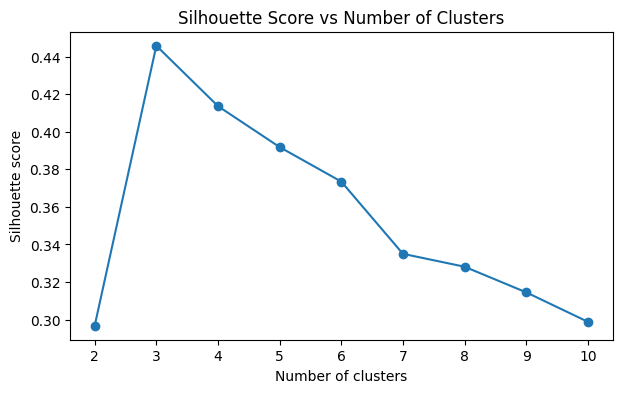

,user_id,cluster
0,1,1
1,4,1
2,6,1
3,7,1
4,9,1
...,...,...
600,4087,1
601,4089,0
602,4090,2
603,4092,1


In [69]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# combined_matrix and users_all should be defined in previous cell

range_n_clusters = range(2, min(11, len(users_all)))  # e.g., try 2-10 clusters, or up to N-1
sil_scores = []
best_score = -1
best_n = None
best_labels = None

for n_clusters in range_n_clusters:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    labels = clustering.fit_predict(combined_matrix)
    # Silhouette expects a distance matrix, not a similarity matrix
    score = silhouette_score(combined_matrix, labels, metric='precomputed')
    sil_scores.append(score)
    if score > best_score:
        best_score = score
        best_n = n_clusters
        best_labels = labels

print(f"Best number of clusters: {best_n} (silhouette score: {best_score:.3f})")

# Optional: Plot silhouette scores
plt.figure(figsize=(7, 4))
plt.plot(list(range_n_clusters), sil_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

# Cluster assignments DataFrame
cluster_df = pd.DataFrame({
    'user_id': users_all,
    'cluster': best_labels
})
display(cluster_df)


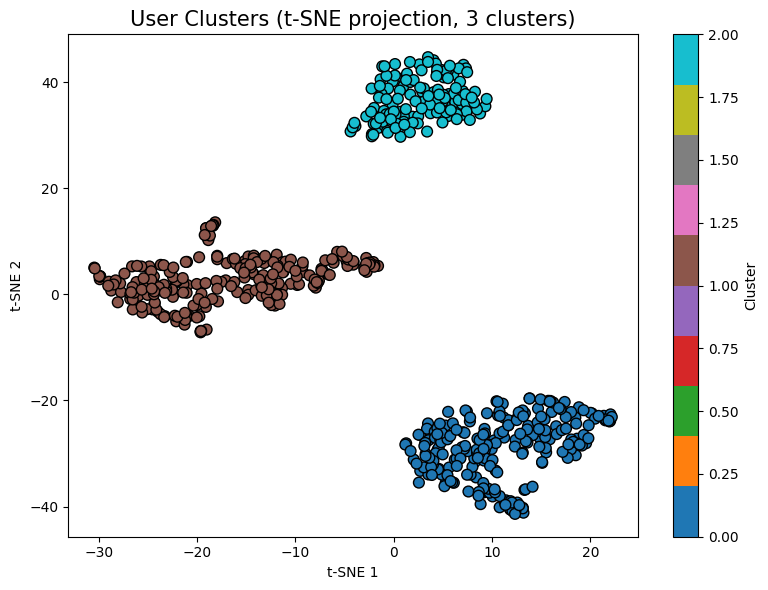

In [70]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# t-SNE works with similarities; precomputed metric expects a distance matrix
tsne = TSNE(n_components=2, metric='precomputed', random_state=42, init='random')
embeddings = tsne.fit_transform(combined_matrix)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings[:, 0], embeddings[:, 1],
    c=best_labels, cmap='tab10', s=60, edgecolor='k'
)
plt.title(f"User Clusters (t-SNE projection, {best_n} clusters)", fontsize=15)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()


In [71]:
cluster_users_dict = (
    cluster_df.groupby('cluster')['user_id']
    .apply(list)
    .to_dict()
)

# Now, cluster_users_dict[0] gives all user_ids in cluster 0, etc.


In [72]:
# average score per cluster

i=0
while i<best_n:
    print(f"Mean percentage for cluster {i} : {zscores[zscores['user_id'].isin(cluster_users_dict[i])].percentage.mean()}")
    print(f"Median percentage for cluster {i} : {zscores[zscores['user_id'].isin(cluster_users_dict[i])].percentage.median()}")

    i+=1
                                        

Mean percentage for cluster 0 : 58.413698523192664
Median percentage for cluster 0 : 64.70588235294117
Mean percentage for cluster 1 : 52.14553875627232
Median percentage for cluster 1 : 58.55411255411255
Mean percentage for cluster 2 : 60.19308935871275
Median percentage for cluster 2 : 68.23529411764706


### Median course durations per cluster

Median durations per course and activity type for cluster 0 : 


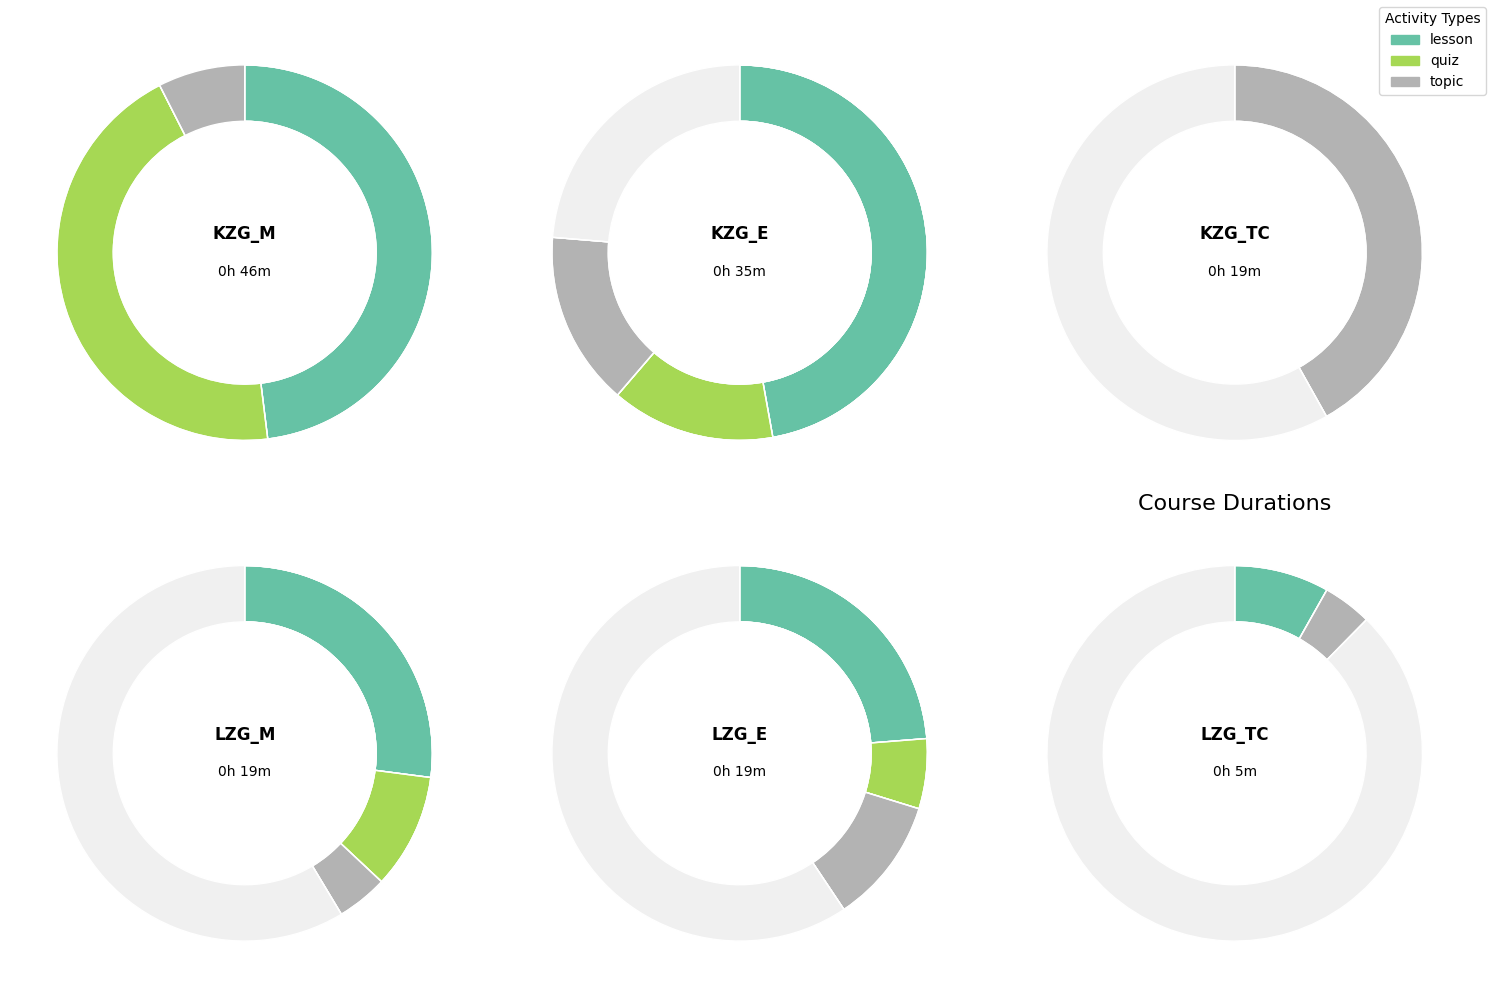

Median durations per course and activity type for cluster 1 : 


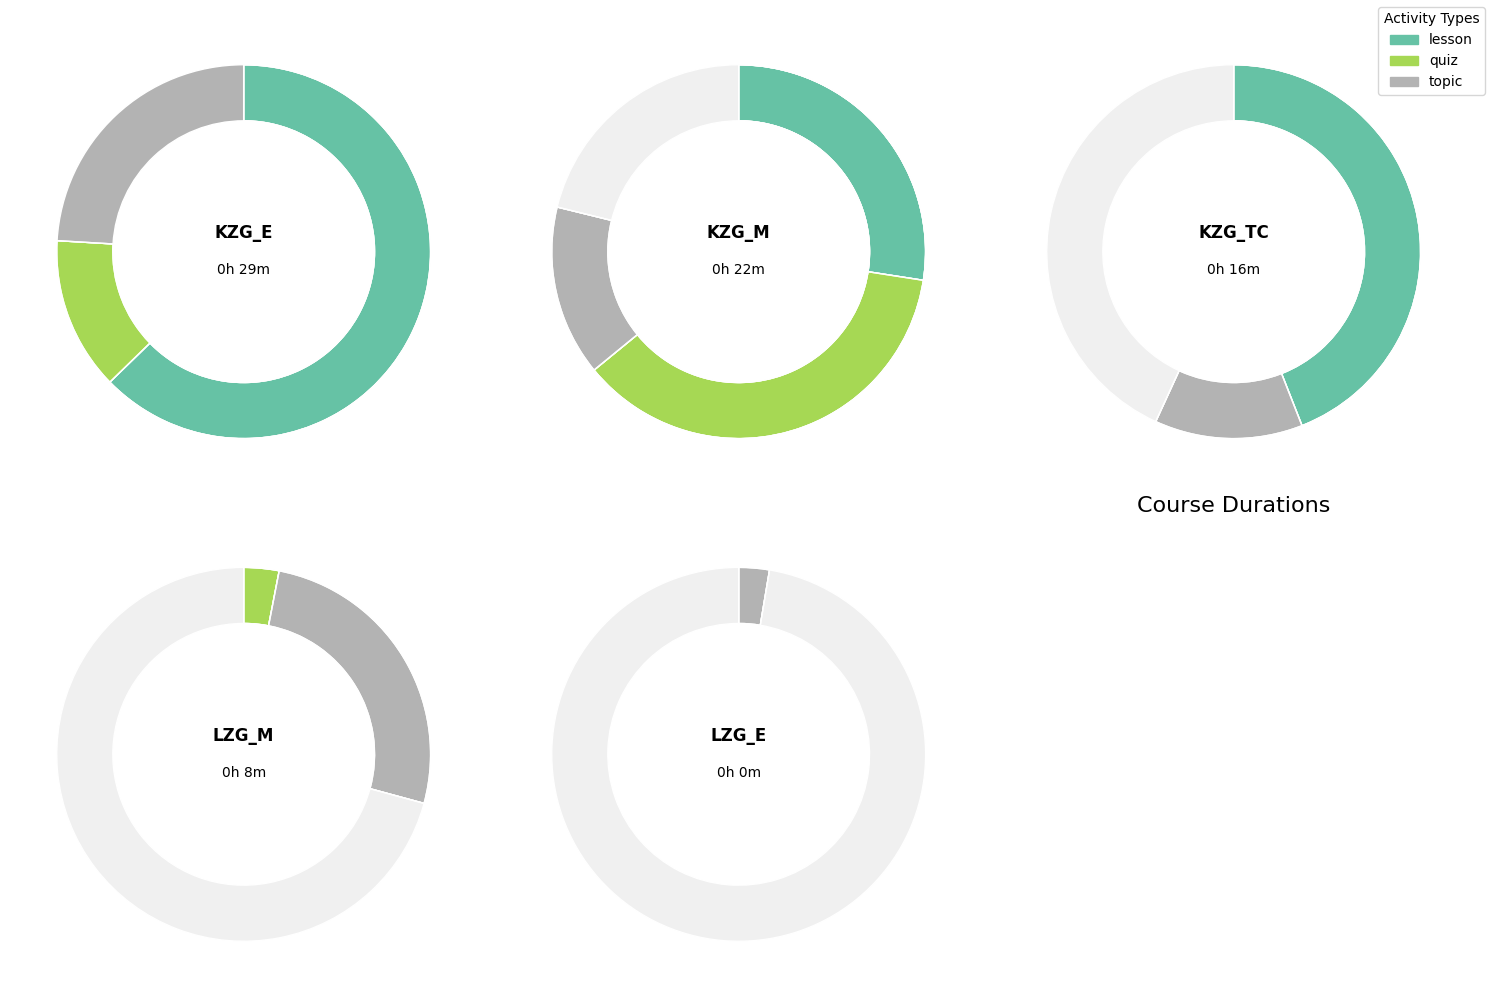

Median durations per course and activity type for cluster 2 : 


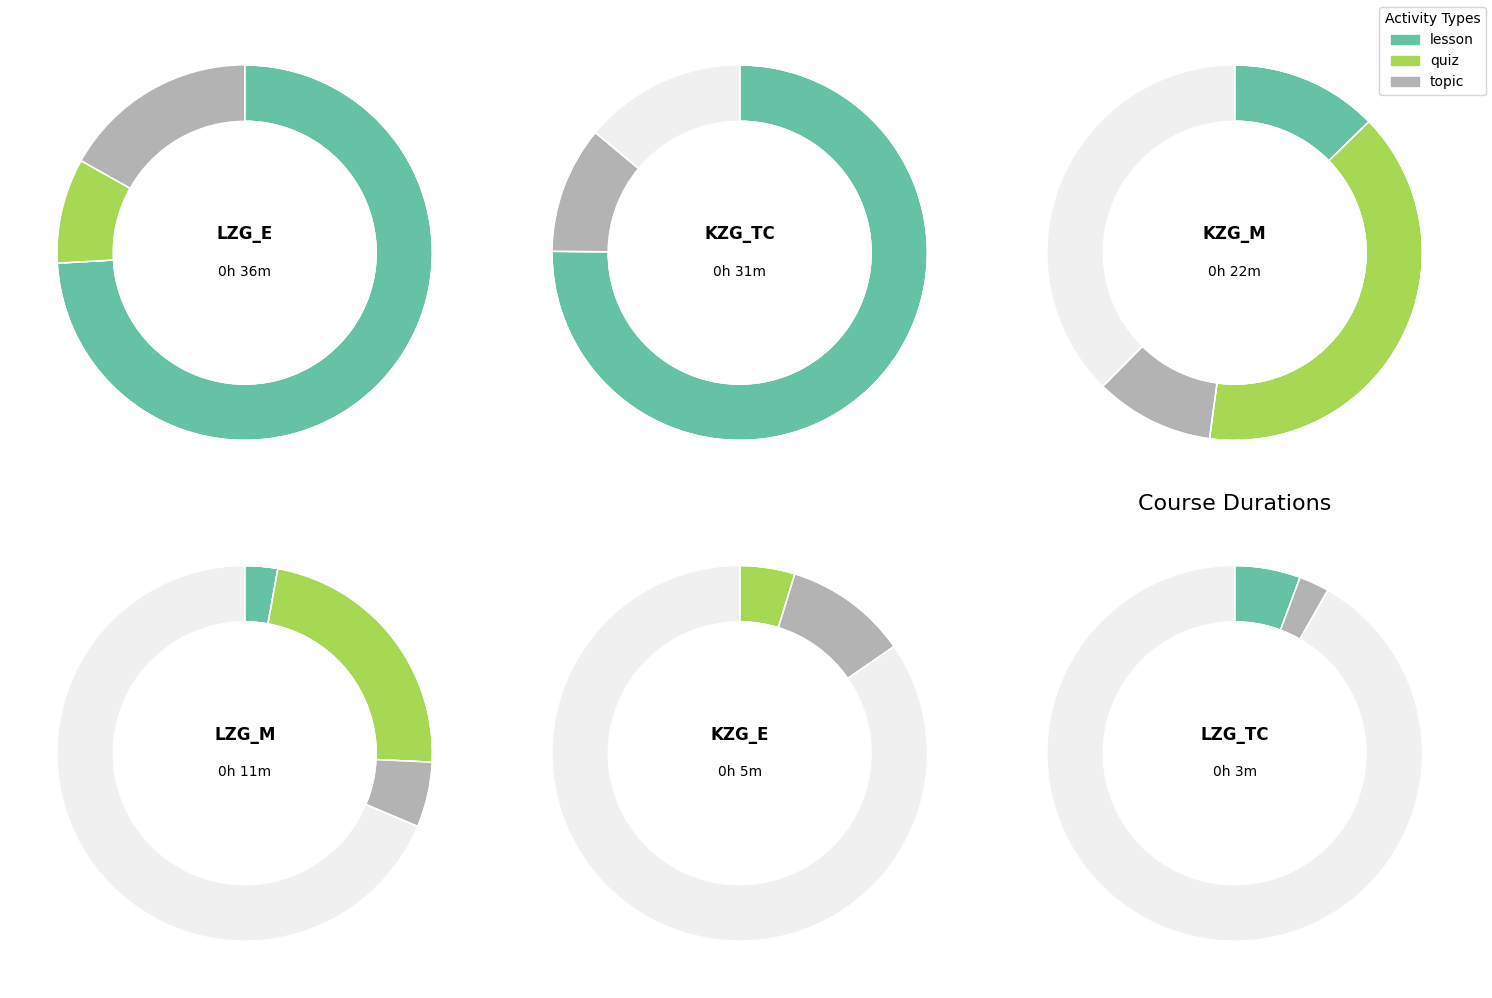

In [73]:
i=0
while i<best_n:
    print(f"Median durations per course and activity type for cluster {i} : ")
    plot_course_durations(
    activities_copy[activities_copy['user_id'].isin(cluster_users_dict[i])]
    .groupby(['course_id', 'activity_type'])['duration'].median().reset_index(),
    course_map_short
)
    i+=1



In [74]:
# import numpy as np
# import pandas as pd
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt

# # combined_matrix: your normalized distance matrix (as above)
# # users_all: your list of user_ids

# # 1. Convert distance matrix to feature vectors (with t-SNE)
# # (You can also use PCA for a faster, linear version. t-SNE is nonlinear and good for visualization)
# feature_dim = 10  # You can try 2, 5, 10, etc.
# tsne = TSNE(metric="precomputed", n_components=feature_dim, random_state=42, init="random")
# features = tsne.fit_transform(combined_matrix)


# # 2. Try different values of k, compute silhouette scores
# scores = []
# ks = range(2, 11)
# for k in ks:
#     kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
#     labels = kmeans.fit_predict(features)
#     score = silhouette_score(features, labels)
#     scores.append(score)

# # 3. Plot silhouette scores to pick the best k
# plt.figure()
# plt.plot(ks, scores, marker='o')
# plt.title('Silhouette score vs. number of clusters')
# plt.xlabel('k (number of clusters)')
# plt.ylabel('Silhouette score')
# plt.show()

# # 4. Select the best k
# best_k = ks[np.argmax(scores)]
# print(f"Best k according to silhouette score: {best_k}")

# # 5. Run KMeans with the best k
# kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
# final_labels = kmeans.fit_predict(features)

# # 6. Visualize in 2D (t-SNE to 2D for plotting)
# tsne2d = TSNE(metric="precomputed", n_components=2, random_state=42)
# embedding_2d = tsne2d.fit_transform(combined_matrix)

# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(
#     embedding_2d[:, 0], embedding_2d[:, 1],
#     c=final_labels, cmap='tab10', s=60, edgecolor='k'
# )
# plt.title('K-Means Clusters (t-SNE 2D projection)')
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.colorbar(scatter, label='Cluster')
# plt.tight_layout()
# plt.show()

# # 7. Optional: create a dataframe of user cluster assignments
# user_cluster_df = pd.DataFrame({
#     'user_id': users_all,
#     'cluster': final_labels
# })
# display(user_cluster_df)
